In [1]:
import functools
import jax
import os

from datetime import datetime
from jax import numpy as jp
import matplotlib.pyplot as plt
from IPython.display import HTML, clear_output

import brax
import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import train as sac

import time
from datetime import datetime

from two_axis_inverted_pendulum_env import TwoAxisInvertedPendulum
from brax.envs.base import Env, PipelineEnv, State

Failed to import warp: No module named 'warp'
Failed to import mujoco_warp: No module named 'warp'


In [2]:
envs.register_environment("TwoAxisInvertedPendulum", TwoAxisInvertedPendulum)
env = envs.get_environment("TwoAxisInvertedPendulum")

# required for parallelizing training
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

/Users/magi/Code/robots/.venv/lib/python3.10/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


In [3]:
# still fine tuning?
train_fn = functools.partial(
    ppo.train,
    num_timesteps=30_000_000, 
    num_evals=20,
    reward_scaling=10,
    episode_length=1000, 
    normalize_observations=True,
    action_repeat=1,
    unroll_length=10, 
    num_minibatches=32,
    num_updates_per_batch=4,
    discounting=0.97,
    learning_rate=3e-4,
    entropy_cost=1e-2,
    num_envs=4096, 
    batch_size=2048,
    seed=1
)

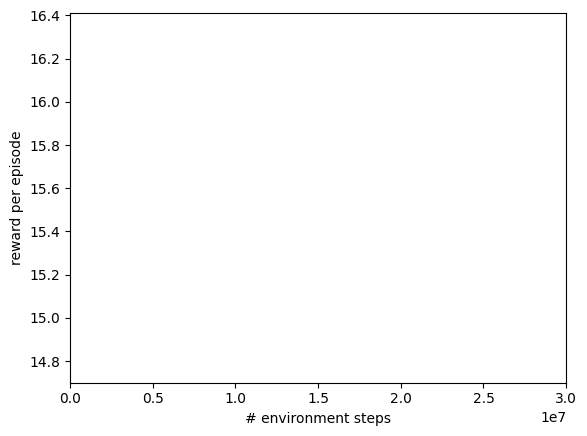

In [ ]:
# code was borrowed from Brax's `tutorial` collab notebook

xdata, ydata = [], []
times = [datetime.now()]
def progress(num_steps, metrics):
    times.append(datetime.now())
    xdata.append(num_steps)
    ydata.append(metrics['eval/episode_reward'])
    clear_output(wait=True)
    plt.xlim([0, train_fn.keywords['num_timesteps']])
    plt.xlabel('# environment steps')
    plt.ylabel('reward per episode')
    plt.plot(xdata, ydata)
    plt.show()

time_start = time.time()
make_inference_fn, params, metrics = train_fn(
    environment=env,
    progress_fn=progress)
time_end = time.time()
print(f"Time to train {(time_end - time_start) / 60 :2f} minutes.")

In [ ]:
model.save_params("policy_1", params)
params = model.load_params("policy_1")
inference_fn = make_inference_fn(params) 

In [ ]:
jit_inference_fn = jax.jit(inference_fn)
rng = jax.random.PRNGKey(0)

state = jit_reset(rng)
rollout = [state.pipeline_state]
rollout_reward = [state.metrics['reward']]
pos = [state.obs[:2]]
x_angle, y_angle = [state.obs[0]], [state.obs[1]]


for _ in range(ROLLOUT_LENGTH):
    act_rng, rng = jax.random.split(rng)
    act, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, act)
    
    if state.done != 0:
        state = jit_reset(rng)

    rollout.append(state.pipeline_state)
    rollout_reward.append(state.metrics['reward'])
    pos.append(state.obs[:2])
    x_angle.append(state.obs[0])
    y_angle.append(state.obs[1])

HTML(html.render(env.sys.tree_replace({'opt.timestep': env.dt}), rollout))


# html_content = html.render(env.sys, rollout)
# with open('trained_rollout_v2.html', 'w') as f:
#     f.write(html_content)

In [ ]:
t